# **NLP_&_INSURANCE: TEXT_ANALYSIS**

![](https://miro.medium.com/max/3310/1*2uLP1885m7LG9f638JlLGQ.png)

## Import Libraries

In [1]:
!pip install bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 2.3 MB/s 
     |████████████████████████████████| 85 kB 2.8 MB/s 
     |████████████████████████████████| 88 kB 4.0 MB/s 
     |████████████████████████████████| 5.2 MB 6.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.4 MB 44.2 MB/s 
     |████████████████████████████████| 1.2 MB 62.6 MB/s 
     |████████████████████████████████| 101 kB 14.0 MB/s 
     |████████████████████████████████| 636 kB 59.0 MB/s 
     |████████████████████████████████| 6.6 MB 47.7 MB/s 
     |████████████████████████████████| 1.1 MB 57.4 MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2342068 sha256=10d5d8fa6fd8e015ff864214f56a0a6fac234e2bbe2f30c57acfb937de12f25a
  Stored in directory: /root/.cache/

In [2]:
!pip install bertopic[visualization]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#setup deterministic results 
import numpy as np
from numpy.random import seed
seed=0
np.random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)
import os
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import re
import string
#import langdetect 
#import ktrain
#from ktrain import text
import spacy
import gensim
from gensim.models import Word2Vec 
import gensim.downloader as gensim_api
from bertopic import BERTopic

## Requirements

In [4]:
print(np.__version__) 

1.21.6


In [5]:
print(pd.__version__) 

1.3.5


In [6]:
print(sklearn.__version__)

1.0.2


In [7]:
print(sns.__version__)

0.11.2


In [8]:
print(tf.__version__)

2.8.2


In [9]:
print(spacy.__version__)

3.3.1


In [10]:
print(gensim.__version__)

3.6.0


## Upload dataset

In [11]:
# https://www.kaggle.com/competitions/nlp-getting-started

In [12]:
df_2 = pd.read_csv('https://raw.githubusercontent.com/claudio1975/NLP_AND_INSURANCE/main/data/train_clean.csv')

In [13]:
# select columns
df_2 = df_2[['id','keyword','location','text','target','lang']]
df_2.head()

,id,keyword,location,text,target,lang
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,en
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,en
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,en
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,en
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,en


## Text pre-processing

In [14]:
nlp = spacy.load("en_core_web_sm")

In [15]:
def lemmatizer(text):        
    lem = []
    doc = nlp(text)
    for word in doc:
        lem.append(word.lemma_)
    return " ".join(lem)
def clean_text(text):
    # Normalize Text
    text = text.lower()
    # Remove Unicode Characters
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", '',text)
    # Remove Punctuaction
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text) 
    # Remove Stopwords
    all_stop_words = nlp.Defaults.stop_words
    text = " ".join([word for word in str(text).split() if word not in all_stop_words])
    # Lemmatization
    text = lemmatizer(text)
    text = re.sub(r'-PRON-', '',text)
    return text


In [16]:
i=3
df_cleaned = pd.DataFrame(df_2.apply(lambda x: clean_text(x.iloc[i]), axis=1), columns = ['text_cleaned'])


In [17]:
df_3 = pd.concat([df_2, df_cleaned], axis=1)

## Document Term-Matrix

In [18]:
tfidf = TfidfVectorizer(ngram_range=(1,1),                       # n_gram_type
                          token_pattern= r'([a-zA-Z0-9-/]{5,})', # num chars >= 5
                          min_df=2).fit(df_3['text_cleaned'])    # minimum required occurences of a word      

In [19]:
train_tfidf = tfidf.transform(df_3['text_cleaned'])

In [20]:
words_tfidf = tfidf.get_feature_names()

## Topic Modelling with BertTopic

In [21]:
model = BERTopic(nr_topics=6,
    vectorizer_model=tfidf,
    calculate_probabilities=True,
    verbose=True)
topics, probs = model.fit_transform(df_3['text_cleaned'])

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/238 [00:00<?, ?it/s]

2022-07-10 04:36:15,870 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-07-10 04:36:55,476 - BERTopic - Reduced dimensionality
2022-07-10 04:37:09,254 - BERTopic - Clustered reduced embeddings
2022-07-10 04:37:10,942 - BERTopic - Reduced number of topics from 196 to 7


In [22]:
freq = model.get_topic_info()
freq.head()

,Topic,Count,Name
0,-1,6454,-1_emergency_train_flood_building
1,0,249,0_suicide_detonate_bomber_attack
2,1,235,1_drown_hundred_rescuer_search
3,2,203,2_crush_sinkhole_swallow_minute
4,3,176,3_hiroshima_nuclear_japan_atomic


In [23]:
model.get_topic(4)

[('california', 0.2679150744221367),
 ('wildfire', 0.2546180656983733),
 ('forest', 0.22478127227362663),
 ('northern', 0.21733348083945445),
 ('national', 0.12924647063223027),
 ('ablaze', 0.09678035471817378),
 ('arsonist', 0.08265405770948027),
 ('arson', 0.0819564930401807),
 ('horse', 0.07661840839113207),
 ('river', 0.07524187806890374)]

In [24]:
model.visualize_barchart()

In [49]:
# LDA and LSA plot
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 3, figsize=(18, 6), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights)
        ax.set_title(f'Topic {topic_idx}',
                     fontdict={'fontsize': 15})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=15)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=12)

    plt.subplots_adjust(top=0.70, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [26]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [27]:
# parameters for LDA and LSA
n_topics = 6
n_top_words = 5

# Topic Modelling with LDA

In [28]:
lda_model = LatentDirichletAllocation(n_components=n_topics, 
                                      learning_method='online',
                                      random_state=seed,       
                                      n_jobs = -1 
                                     )

In [29]:
lda_train = lda_model.fit(train_tfidf)
lda_train_topic_results = lda_model.transform(train_tfidf)


In [30]:
print_top_words(lda_train, words_tfidf, 5)

Topic #0:
scream wreck family wildfire people
Topic #1:
video weapon california police death
Topic #2:
disaster flood crush smoke thunder
Topic #3:
think storm today attack nuclear
Topic #4:
suicide survive destroy siren watch
Topic #5:
world woman quarantine reddit earthquake



In [31]:
for topic_idx, topic in enumerate(lda_train.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [words_tfidf[i] for i in top_features_ind]
        weights = topic[top_features_ind]/100
        print(top_features)
        print(weights)

['scream', 'wreck', 'family', 'wildfire', 'people']
[0.72687501 0.71223283 0.44361544 0.44219903 0.4298505 ]
['video', 'weapon', 'california', 'police', 'death']
[0.58551805 0.45268275 0.44962393 0.43637066 0.40300806]
['disaster', 'flood', 'crush', 'smoke', 'thunder']
[0.50694342 0.45348209 0.33951047 0.3192145  0.302535  ]
['think', 'storm', 'today', 'attack', 'nuclear']
[0.52894724 0.41071002 0.34570447 0.33920702 0.29135329]
['suicide', 'survive', 'destroy', 'siren', 'watch']
[0.48559762 0.44733438 0.35426467 0.33169786 0.32785587]
['world', 'woman', 'quarantine', 'reddit', 'earthquake']
[0.42930625 0.28145568 0.27261674 0.26535531 0.26268278]


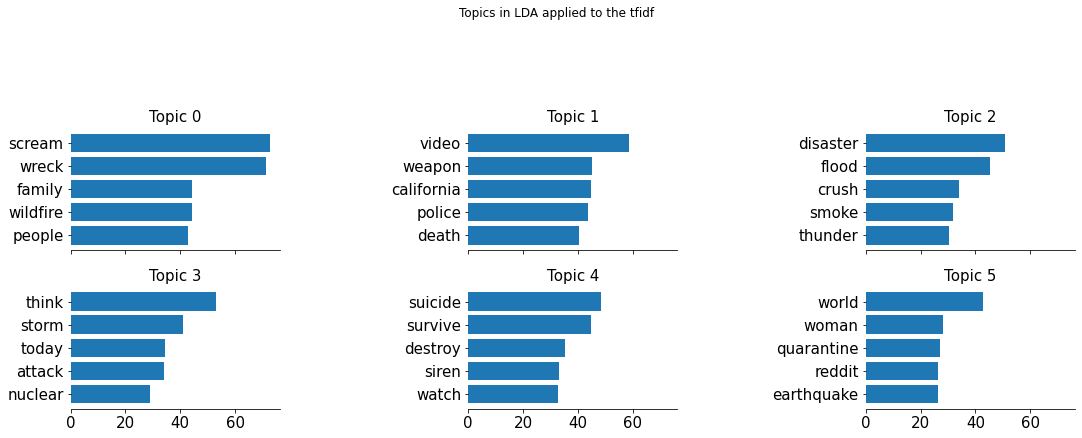

In [50]:
plot_top_words(lda_train, words_tfidf, n_top_words, 'Topics in LDA applied to the tfidf')

## Topic Modelling with LSA

In [34]:
lsa_model = TruncatedSVD(n_components=n_topics, n_iter=10, random_state=seed)

In [35]:
lsa_train = lsa_model.fit(train_tfidf)
lsa_train_topic_results = lsa_model.transform(train_tfidf)

In [36]:
print_top_words(lsa_train, words_tfidf, 5)

Topic #0:
scream california people wildfire northern
Topic #1:
california wildfire northern disaster obama
Topic #2:
crash people video drown family
Topic #3:
suicide bomber drown detonate turkey
Topic #4:
suicide bomber detonate family turkey
Topic #5:
drown family malaysia confirm wreckage



In [37]:
for topic_idx, topic in enumerate(lsa_train.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [words_tfidf[i] for i in top_features_ind]
        weights = topic[top_features_ind]/100
        print(top_features)
        print(weights)

['scream', 'california', 'people', 'wildfire', 'northern']
[0.00957761 0.00101956 0.00097167 0.00086566 0.00073982]
['california', 'wildfire', 'northern', 'disaster', 'obama']
[0.00623603 0.00533984 0.00458129 0.00110831 0.00077161]
['crash', 'people', 'video', 'drown', 'family']
[0.00326293 0.00279683 0.0026481  0.00223342 0.00204151]
['suicide', 'bomber', 'drown', 'detonate', 'turkey']
[0.00349868 0.00237862 0.002256   0.00175611 0.00144847]
['suicide', 'bomber', 'detonate', 'family', 'turkey']
[0.00374721 0.00267988 0.00200944 0.00187791 0.00165063]
['drown', 'family', 'malaysia', 'confirm', 'wreckage']
[0.00724262 0.00239678 0.00134099 0.00129597 0.00122119]


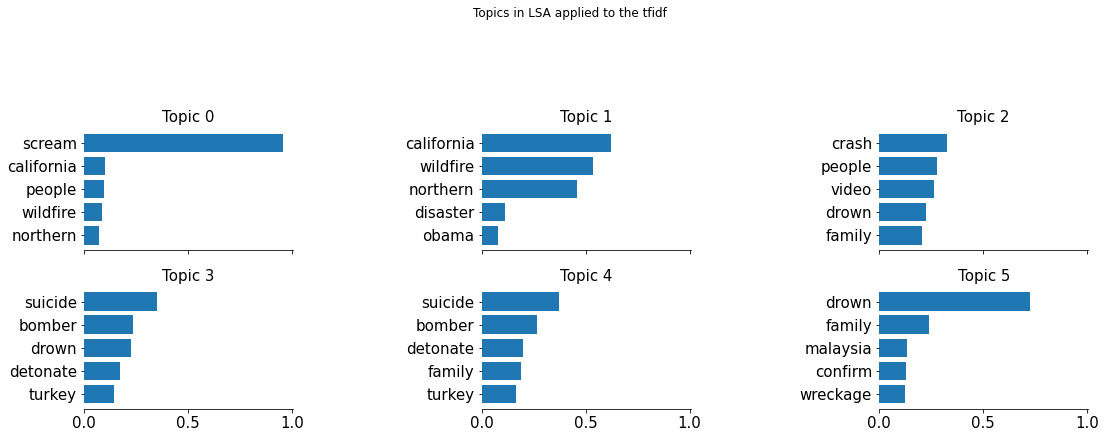

In [51]:
plot_top_words(lsa_train, words_tfidf, n_top_words, 'Topics in LSA applied to the tfidf')

In [ ]:
# export data set
#from google.colab import files
#df_3.to_csv('df_train.csv')
#files.download('df_train.csv') 